# Model Evaluations

In [1]:
import os
import sys
from pathlib import Path

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt


sys.path.append('../..')
from airfoil_rans.fnogno._config import DefaultConfig
from airfoil_rans.fnogno._dataset import Dataset, Processor, generate_latent_queries
from airfoil_rans.utils import get_sample, compute_force
from surrogates.models import FNOGNO


DATA_PATH = '/workspace/data/airfoil_subsonic_rans/'
SURROGATE_PATH = '/workspace/ShapeOpt/airfoil_rans/fnogno/tmp/1005_071006/'
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

config = DefaultConfig
if not config.data.skin_friction_lift and config.model.out_channels == 3:
    config.model.out_channels = 2
    print("config.model.out_channels has been set to 2 becuase skin friction lift is ignored", flush=True)
    
n_data = config.data.n_data
print(f"{n_data=}")

n_data=18186


## Load Dataset and Model

In [2]:
class WrappedModel(nn.Module):
    def __init__(self, model, processor, in_p_res=64, domain_lims=[[-40, 40], [-40, 40]], only_surface=True):
        super(WrappedModel, self).__init__()
        self.model = model
        self.processor = processor

        self.surface_only = only_surface
        self.in_p_res = in_p_res
        self.domain_lims = domain_lims
        self.in_p = torch.nn.Parameter(generate_latent_queries(in_p_res, domain_lims=domain_lims), requires_grad=False)

        self._freeze()

    def _freeze(self):
        for param in self.model.parameters():
            param.requires_grad = False
        for param in self.processor.parameters():
            param.requires_grad = False

    def forward(self, surface, nodes=None):

        surface = surface.to(DEVICE).reshape(-1, 2)

        input_geom = self.in_p.view(1, -1, 2).to(DEVICE)
        dists = torch.cdist(input_geom, surface)
        sdf, _ = dists.min(dim=-1)
        sdf = sdf.reshape(self.in_p_res, self.in_p_res, 1)

        if self.surface_only or nodes == None:
            out = self.model(in_p=self.in_p, out_p=surface, f=sdf)
        else:
            out = self.model(in_p=self.in_p, out_p=nodes, f=sdf)

        out, _ = self.processor.postprocess(out, sample=None)

        return out

In [3]:
dataset = Dataset(data_path=DATA_PATH,
                  n_data=config.data.n_data,
                  n_train=config.data.n_train,
                  n_test=config.data.n_test,
                  only_surface=config.data.only_surface,
                  in_p_res=config.data.in_p_res,
                  domain_lims=config.data.domain_lims,
                  normalize_y=config.data.normalize_y,
                  skin_friction_lift=config.data.skin_friction_lift)

processor = Processor(normalizers=dataset.normalizers, device=DEVICE)
processor.eval()

raw_model = FNOGNO(
        in_channels=config.model.in_channels,
        out_channels=config.model.out_channels,
        gno_coord_dim=config.model.gno_coord_dim,
        fno_n_modes=config.model.fno_n_modes,
        fno_n_layers=config.model.fno_n_layers,
        fno_factorization=config.model.fno_factorization,
        fno_rank=config.model.fno_rank,
        gno_radius=config.model.gno_radius,
        gno_weighting_function=config.model.gno_weighting_function,
        gno_weight_function_scale=config.model.gno_weight_function_scale,
        gno_use_open3d=False,
    ).to(DEVICE)
model_state_dict = torch.load(os.path.join(
    SURROGATE_PATH, "model_state_dict.pt"), map_location=DEVICE, weights_only=False)
raw_model.load_state_dict(model_state_dict)
raw_model.eval()

only_surface = config.data.only_surface
print(f"{only_surface=}")
surrogate = WrappedModel(model=raw_model, processor=processor, in_p_res=config.data.in_p_res, domain_lims=config.data.domain_lims, only_surface=config.data.only_surface).to(DEVICE)

only_surface=True


## Evaluations

In [4]:
def plot_surface(nodes_b, f_b1, f_b2, v=None, title_str=None):

    if isinstance(nodes_b, torch.Tensor):
        nodes_b = nodes_b.detach().cpu().numpy()
    if isinstance(f_b1, torch.Tensor):
        f_b1 = f_b1.detach().cpu().numpy()
    if isinstance(f_b2, torch.Tensor):
        f_b2 = f_b2.detach().cpu().numpy()

    nodes_b = nodes_b.reshape(-1, 2)
    f_b1 = f_b1.reshape(-1)
    f_b2 = f_b2.reshape(-1)

    xb, yb = nodes_b[..., 0], nodes_b[..., 1]

    if v is None:
        vmin, vmax = min(f_b1.min(), f_b2.min()), max(f_b1.max(), f_b2.max())
    else:
        vmin, vmax = v

    fig, ax = plt.subplots(ncols=3, figsize=(20, 3))

    ax[0].scatter(xb, yb, c=f_b1, vmin=vmin, vmax=vmax, label='Prediction')
    ax[0].axis('equal')
    ax[0].axis('off')

    sc = ax[1].scatter(xb, yb, c=f_b2, vmin=vmin, vmax=vmax, label='Ground Truth')
    ax[1].axis('equal')
    ax[1].axis('off')
    plt.colorbar(sc, ax=[ax[0], ax[1]])

    sc = ax[2].scatter(xb, yb, c=f_b2 - f_b1, label='Error')
    ax[2].axis('equal')
    ax[2].axis('off')
    plt.colorbar(sc, ax=[ax[2]])

    ax[0].set_title('Prediction')
    ax[1].set_title('Ground Truth')
    ax[2].set_title('Error')

    if title_str is not None:
        fig.suptitle(title_str)

In [5]:
from train_fnogno import LpLoss

lploss = LpLoss(d=2, p=2)

data_path = Path(DATA_PATH).expanduser().resolve()
global_features = np.load(data_path / 'raw_data' / 'global_features.npz')
CL_list = global_features['cl']
CD_list = global_features['cd']
tags = ['press', 'friction_x', 'friction_y']


def eval_sample(idx, plot=False):
    surface, truth = get_sample(idx, data_path)
    surface = torch.tensor(surface, dtype=torch.float)
    truth = torch.tensor(truth, dtype=torch.float)

    pred = surrogate(surface).cpu()

    cl_pred, cd_pred = compute_force(surface, pred)
    cl_gt, cd_gt = CL_list[idx], CD_list[idx]

    if plot:

        _, ax = plt.subplots(ncols=3, nrows=3, figsize=(20, 20))
        for j in range(3):
            ax[j, 0].plot(surface[:, 0], pred[:, j])
            ax[j, 1].plot(surface[:, 0], truth[:, j])
            ax[j, 2].plot(surface[:, 0], truth[:, j] - pred[:, j])

        ax[0, 0].set_title('Prediction')
        ax[0, 1].set_title('Ground Truth')
        ax[0, 2].set_title('Error')

        # for j in range(3):
        #     plot_surface(surface, pred[..., j], truth[..., j], title_str=tags[j])
        #     plt.legend()

    lploss_val = lploss(pred, truth)
    press_loss_val = lploss(pred[..., [0]], truth[..., [0]])
    friction_x_loss_val = lploss(pred[..., [1]], truth[..., [1]])
    friction_y_loss_val = lploss(pred[..., [2]], truth[..., [2]])
    ratio_pred, ratio_gt = cl_pred / cd_pred, cl_gt / cd_gt

    return ratio_pred, ratio_gt, cl_pred, cd_pred, cl_gt, cd_gt, lploss_val, press_loss_val, friction_x_loss_val, friction_y_loss_val

In [6]:
from tqdm import tqdm
cl_preds, cd_preds, lp_losses, press_losses, friction_x_losses, friction_y_losses = [], [], [], [], [], []

for idx in tqdm(range(n_data)):
    _, _, cl_pred, cd_pred, _, _, lploss_val, press_loss_val, friction_x_loss_val, friction_y_loss_val = eval_sample(idx)
    cl_preds.append(cl_pred)
    cd_preds.append(cd_pred)
    lp_losses.append(press_loss_val)
    press_losses.append(press_loss_val)
    friction_x_losses.append(friction_x_loss_val)
    friction_y_losses.append(friction_y_loss_val)

cl_preds = np.array(cl_preds)
cd_preds = np.array(cd_preds)
lp_losses = np.array(lp_losses)
press_losses = np.array(press_losses)
friction_x_losses = np.array(friction_x_losses)
friction_y_losses = np.array(friction_y_losses)

np.savez(SURROGATE_PATH + 'saved_preds.npz',
         cl_preds=cl_preds,
         cd_preds=cd_preds,
         lp_losses=lp_losses,
         press_losses=press_losses,
         friction_x_losses=friction_x_losses,
         friction_y_losses=friction_y_losses)

100%|██████████| 18186/18186 [04:44<00:00, 63.83it/s]


### Error distribution

In [7]:
n_train = config.data.n_train

data_pred = np.load(SURROGATE_PATH + 'saved_preds.npz')
cl_preds = data_pred['cl_preds']
cd_preds = data_pred['cd_preds']
lp_losses = data_pred['lp_losses']
press_losses = data_pred['press_losses']
friction_x_losses = data_pred['friction_x_losses']
friction_y_losses = data_pred['friction_y_losses']

ratio_preds = cl_preds / cd_preds
ratio_gts = CL_list / CD_list
ratio_losses = ratio_preds - ratio_gts
rel_ratio_losses = np.abs(ratio_losses) / ratio_gts

train_color = "#1f77b4"
test_color = "#ff7f0e"

aoa_list = [a for a in range(-5, 11)]

- $C_L/C_D$

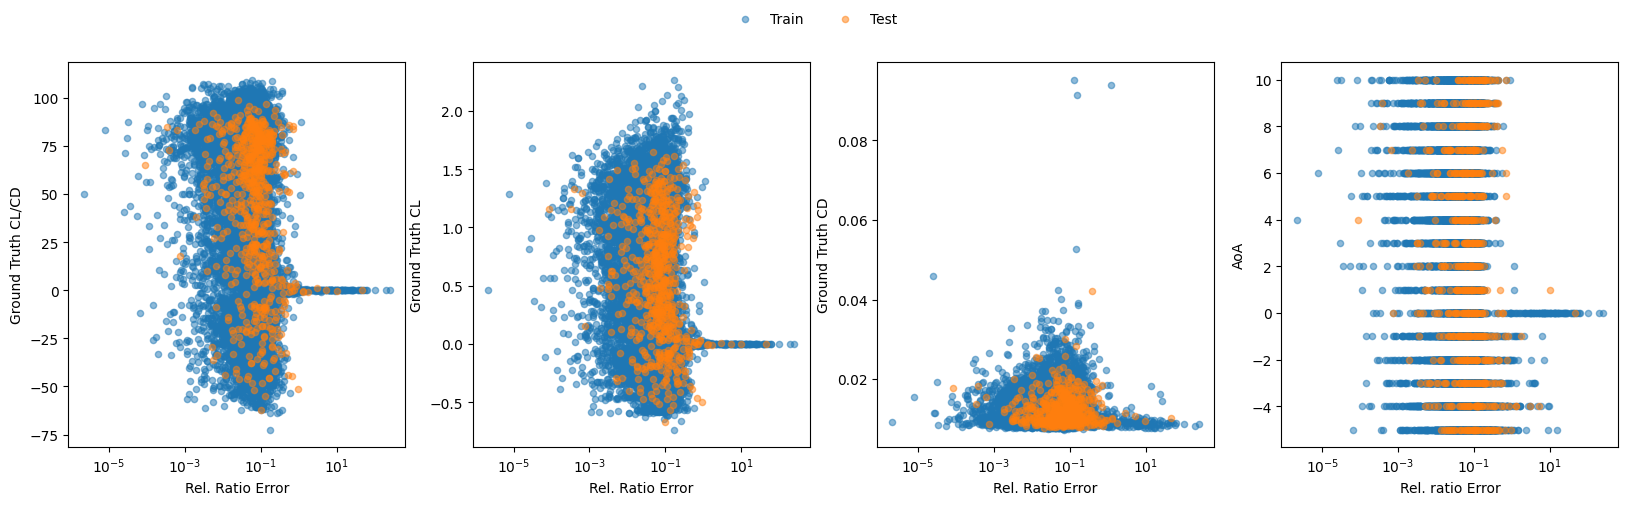

In [8]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharex=True)

axes[0].scatter(np.abs(rel_ratio_losses[:n_train]), ratio_gts[:n_train],
                s=20, alpha=0.5, color=train_color, label='Train')
axes[0].scatter(np.abs(rel_ratio_losses[n_train:]), ratio_gts[n_train:],
                s=20, alpha=0.5, color=test_color, label='Test')
axes[0].set_xscale('log')
axes[0].set_xlabel("Rel. Ratio Error")
axes[0].set_ylabel("Ground Truth CL/CD")

axes[1].scatter(np.abs(rel_ratio_losses[:n_train]), CL_list[:n_train],
                s=20, alpha=0.5, color=train_color)
axes[1].scatter(np.abs(rel_ratio_losses[n_train:]), CL_list[n_train:],
                s=20, alpha=0.5, color=test_color)
axes[1].set_xscale('log')
axes[1].set_xlabel("Rel. Ratio Error")
axes[1].set_ylabel("Ground Truth CL")

axes[2].scatter(np.abs(rel_ratio_losses[:n_train]), CD_list[:n_train],
                s=20, alpha=0.5, color=train_color)
axes[2].scatter(np.abs(rel_ratio_losses[n_train:]), CD_list[n_train:],
                s=20, alpha=0.5, color=test_color)
axes[2].set_xscale('log')
axes[2].set_xlabel("Rel. Ratio Error")
axes[2].set_ylabel("Ground Truth CD")

axes[3].scatter(np.abs(rel_ratio_losses[:n_train]), global_features['aoa'][:n_train], s=20, alpha=0.5, color=train_color)
axes[3].scatter(np.abs(rel_ratio_losses[n_train:]), global_features['aoa'][n_train:], s=20, alpha=0.5, color=test_color)
axes[3].set_xscale('log')
axes[3].set_xlabel("Rel. ratio Error")
axes[3].set_ylabel("AoA")

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=2, frameon=False)
plt.show()

Train Rel. Ratio Error
AoA=-5:  0.1427201948748918
AoA=-4:  0.1381938328464705
AoA=-3:  0.09498622214513835
AoA=-2:  0.09313367012386685
AoA=-1:  0.09310878964379443
AoA=0:  1.5867225982650404
AoA=1:  0.06924703448854239
AoA=2:  0.06359540927255194
AoA=3:  0.058432306737969925
AoA=4:  0.05418229071799748
AoA=5:  0.05220644828221805
AoA=6:  0.05242183773414584
AoA=7:  0.05131009585002383
AoA=8:  0.05500345178009366
AoA=9:  0.056324946718309565
AoA=10:  0.06887563130583951

Test Rel. Ratio Error
AoA=-5:  0.15962921442444805
AoA=-4:  0.36755747925435067
AoA=-3:  0.12375302236832705
AoA=-2:  0.13082022912302635
AoA=-1:  0.15456002654359782
AoA=0:  1.0098495898671103
AoA=1:  0.30269321409124467
AoA=2:  0.06774158216296366
AoA=3:  0.07001922863721191
AoA=4:  0.07570346072433783
AoA=5:  0.07058487447554226
AoA=6:  0.08475890266891206
AoA=7:  0.07007965654827712
AoA=8:  0.10374907992456833
AoA=9:  0.12440470380054984
AoA=10:  0.1442468082845093


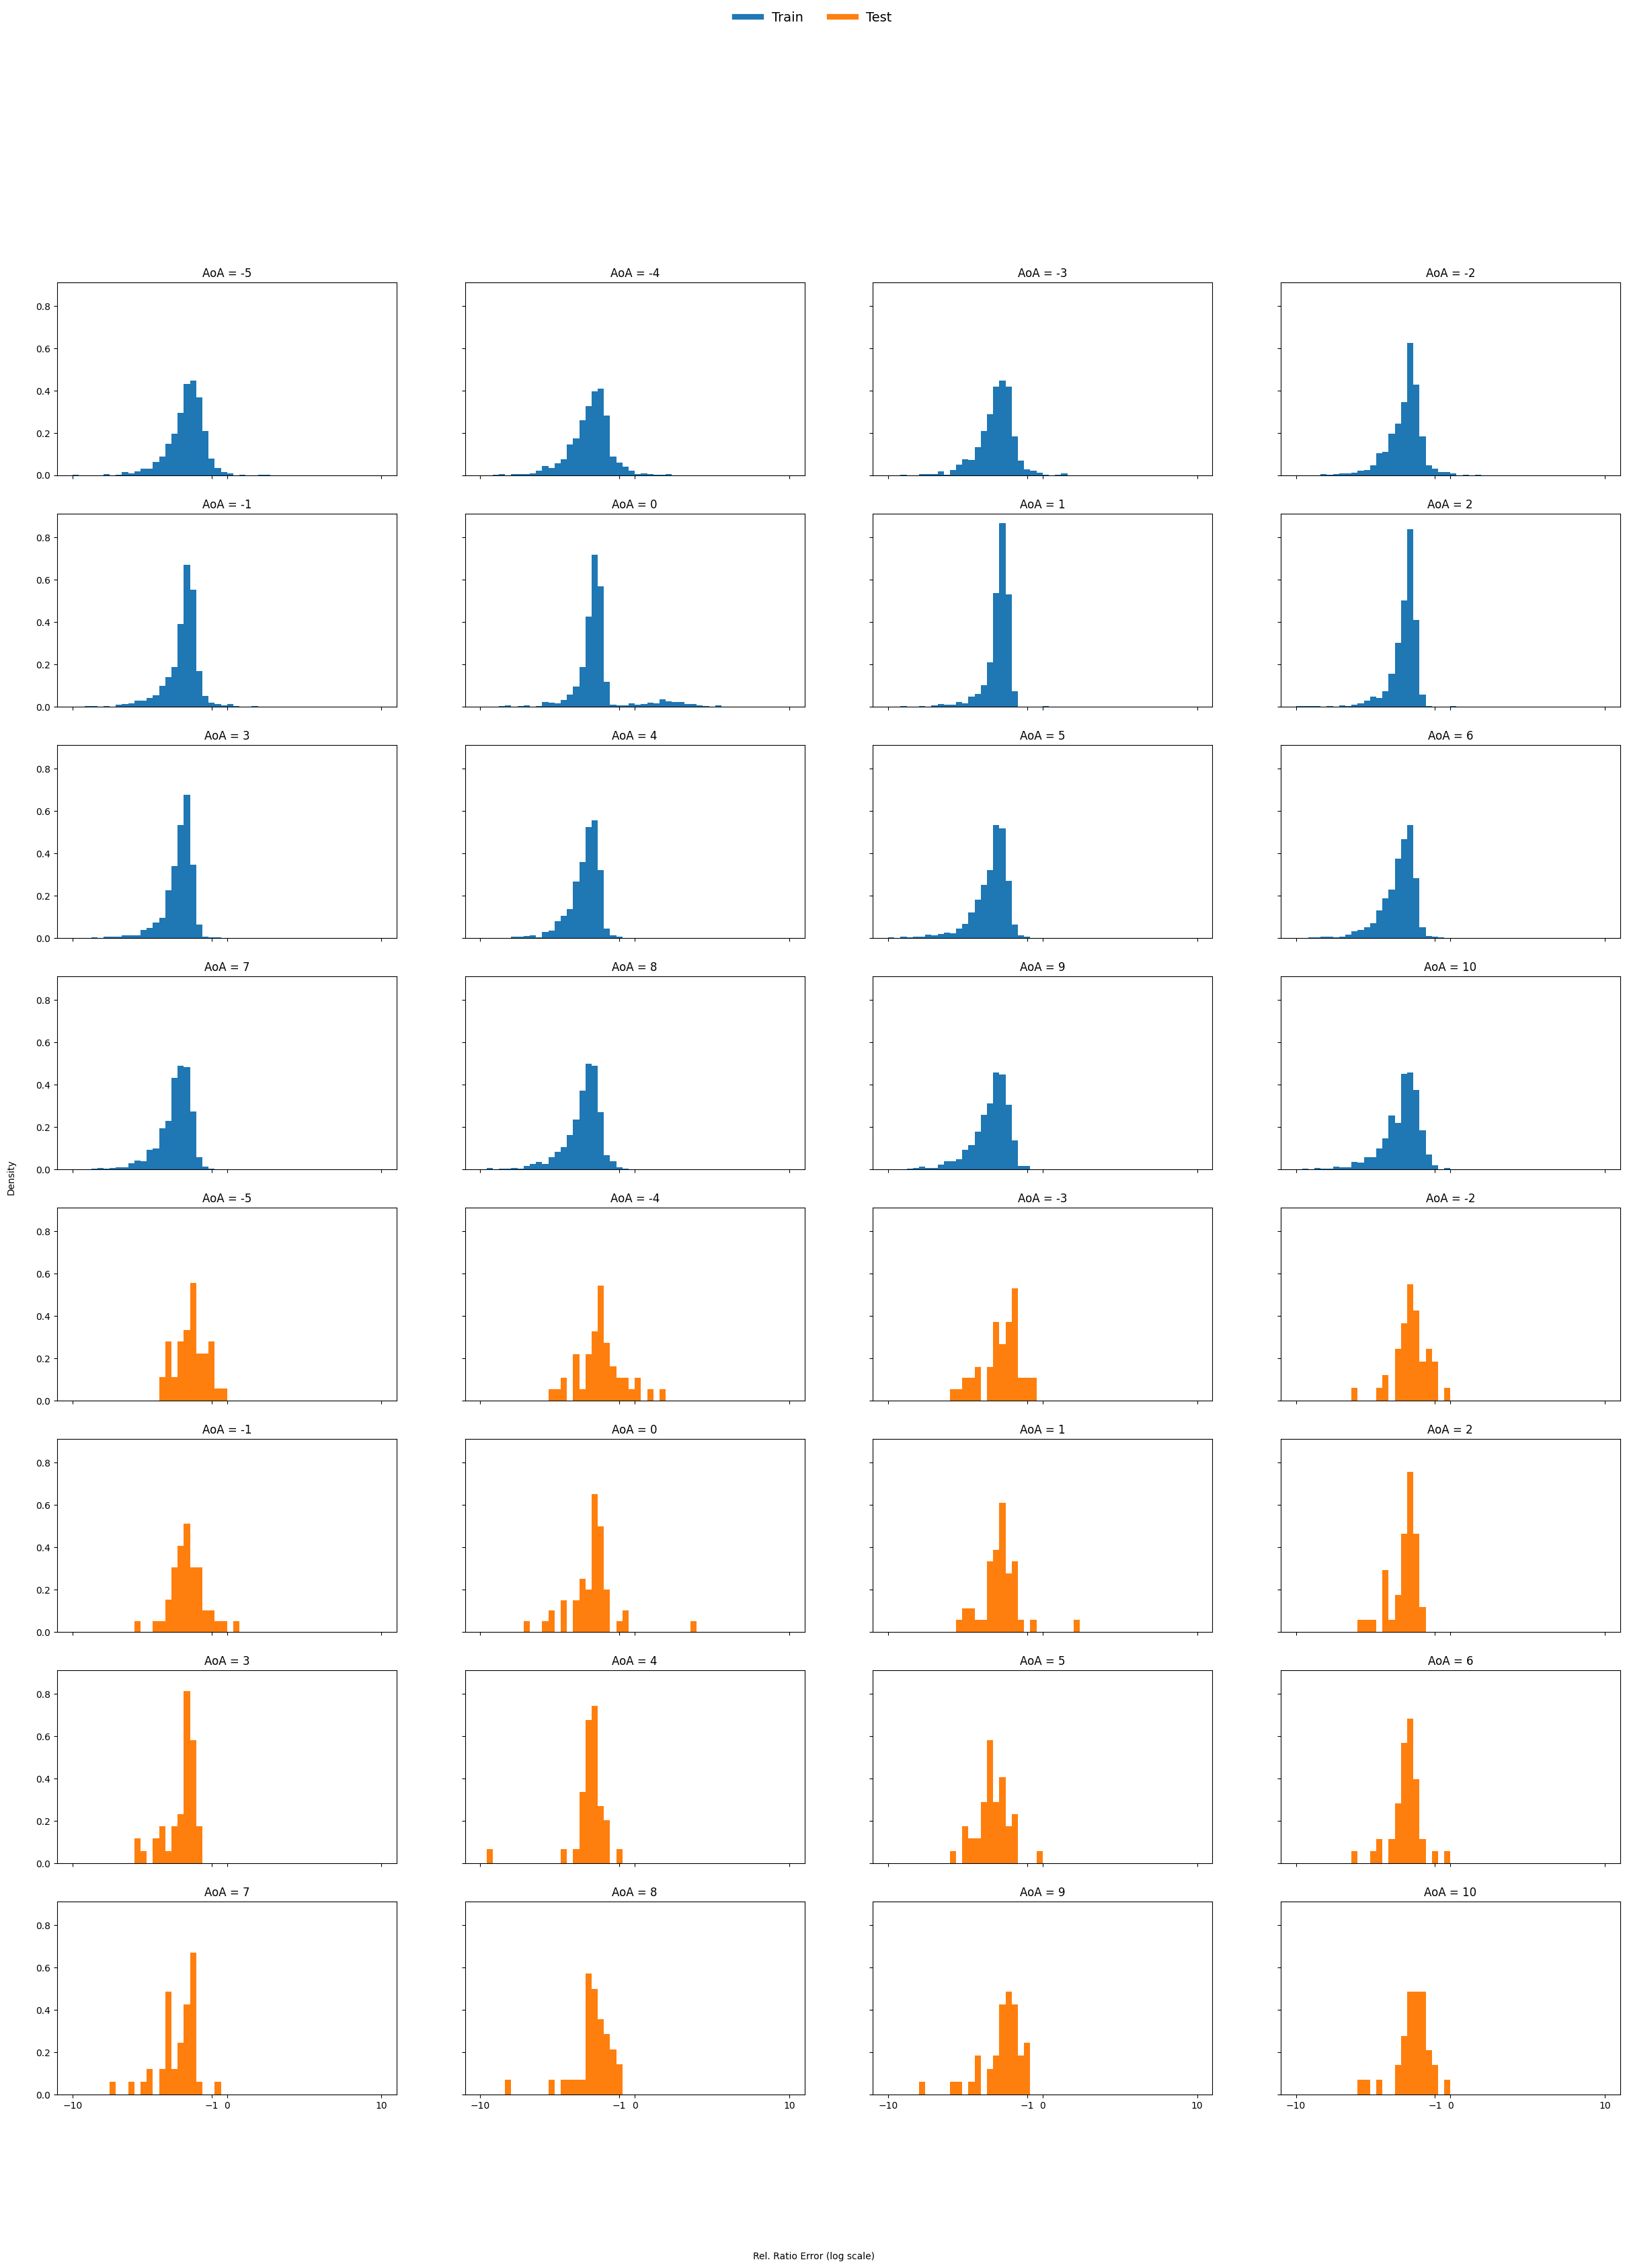

In [10]:
fig, axes = plt.subplots(8, 4, figsize=(30, 35), sharex=True, sharey=True)
axes = axes.flatten()
bins = np.linspace(-10, 10, 51)

aoas = global_features['aoa'][:n_train]
log_rel_loss = np.log(np.abs(rel_ratio_losses))[:n_train]

print("Train Rel. Ratio Error")
train_errors = []
i = 0
for aoa in aoa_list:
    mask = (aoas == aoa)
    errors = log_rel_loss[mask]
    train_errors.append(np.mean(np.exp(errors)))

    axes[i].hist(errors, bins=bins, color=train_color, density=True)
    axes[i].set_title(f"AoA = {aoa}")
    print(f"AoA={aoa}:  {train_errors[i]}")
    i += 1


aoas = global_features['aoa'][n_train:]
log_rel_loss = np.log(np.abs(rel_ratio_losses))[n_train:]

print("\nTest Rel. Ratio Error")
test_errors = []

for aoa in aoa_list:
    mask = (aoas == aoa)
    errors = log_rel_loss[mask]
    test_errors.append(np.mean(np.exp(errors)))

    axes[i].hist(errors, bins=bins, color=test_color, density=True)
    axes[i].set_xticks([-10, -1, 0, 10])
    axes[i].set_title(f"AoA = {aoa}")
    print(f"AoA={aoa}:  {test_errors[i-len(aoa_list)]}")
    i += 1


fig.text(0.5, 0.04, 'Rel. Ratio Error (log scale)', ha='center')
fig.text(0.1, 0.5, 'Density', va='center', rotation='vertical')
handles = [
    plt.Line2D([0], [0], color=train_color, lw=6, label='Train'),
    plt.Line2D([0], [0], color=test_color, lw=6, label='Test')
]
fig.legend(handles=handles, loc='upper center', ncol=2, fontsize=14, frameon=False)

plt.show()

- $L_2$ 

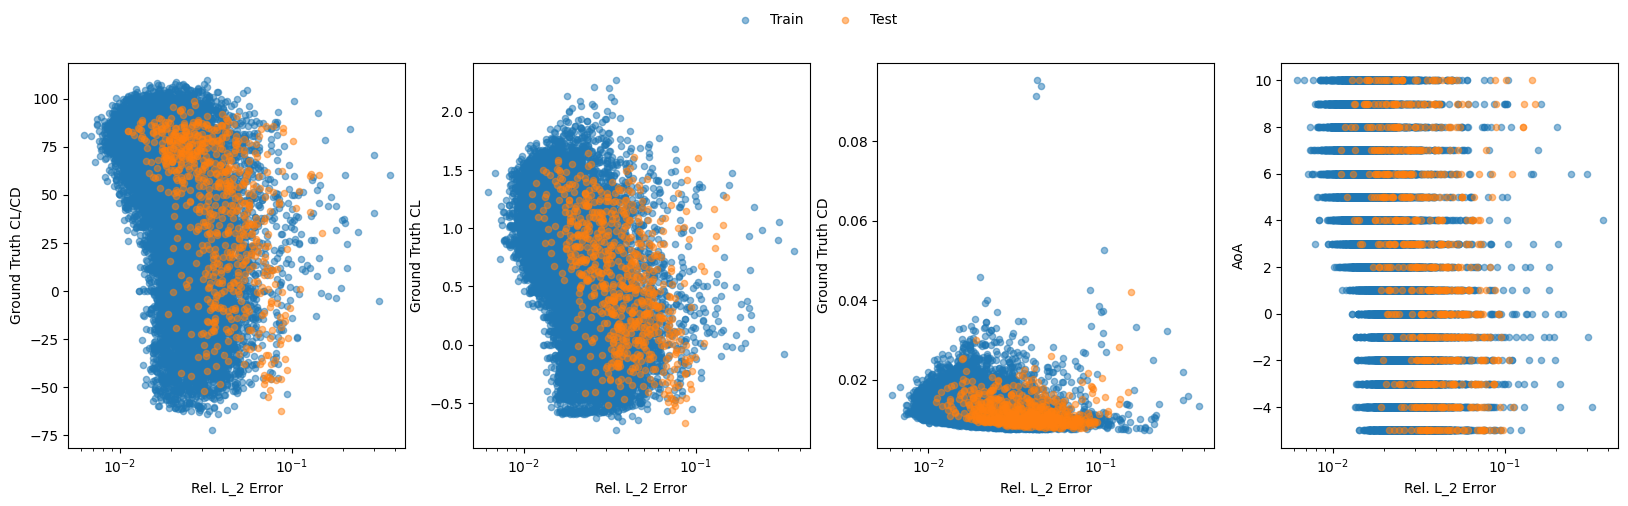

In [11]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharex=True)

axes[0].scatter(lp_losses[:n_train], ratio_gts[:n_train], s=20, alpha=0.5, color=train_color, label='Train')
axes[0].scatter(lp_losses[n_train:], ratio_gts[n_train:], s=20, alpha=0.5, color=test_color, label='Test')
axes[0].set_xscale('log')
axes[0].set_xlabel("Rel. L_2 Error")
axes[0].set_ylabel("Ground Truth CL/CD")

axes[1].scatter(lp_losses[:n_train], CL_list[:n_train], s=20, alpha=0.5, color=train_color)
axes[1].scatter(lp_losses[n_train:], CL_list[n_train:], s=20, alpha=0.5, color=test_color)
axes[1].set_xscale('log')
axes[1].set_xlabel("Rel. L_2 Error")
axes[1].set_ylabel("Ground Truth CL")

axes[2].scatter(lp_losses[:n_train], CD_list[:n_train], s=20, alpha=0.5, color=train_color)
axes[2].scatter(lp_losses[n_train:], CD_list[n_train:], s=20, alpha=0.5, color=test_color)
axes[2].set_xscale('log')
axes[2].set_xlabel("Rel. L_2 Error")
axes[2].set_ylabel("Ground Truth CD")

axes[3].scatter(lp_losses[:n_train], global_features['aoa'][:n_train], s=20, alpha=0.5, color=train_color)
axes[3].scatter(lp_losses[n_train:], global_features['aoa'][n_train:], s=20, alpha=0.5, color=test_color)
axes[3].set_xscale('log')
axes[3].set_xlabel("Rel. L_2 Error")
axes[3].set_ylabel("AoA")

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=2, frameon=False)
plt.show()

Train Rel. L2 Error
AoA=-5:  0.03143879026174545
AoA=-4:  0.030104439705610275
AoA=-3:  0.029030917212367058
AoA=-2:  0.029327506199479103
AoA=-1:  0.03012239746749401
AoA=0:  0.0286257341504097
AoA=1:  0.02551572024822235
AoA=2:  0.022352691739797592
AoA=3:  0.020413873717188835
AoA=4:  0.018930716440081596
AoA=5:  0.0175506379455328
AoA=6:  0.017494797706604004
AoA=7:  0.017038634046912193
AoA=8:  0.01692879945039749
AoA=9:  0.01674109511077404
AoA=10:  0.018284199759364128

Test Rel. L2 Error
AoA=-5:  0.048867251724004745
AoA=-4:  0.04776512458920479
AoA=-3:  0.04572095349431038
AoA=-2:  0.051678676158189774
AoA=-1:  0.04936850816011429
AoA=0:  0.04841635748744011
AoA=1:  0.04431094229221344
AoA=2:  0.037213284522295
AoA=3:  0.03420398756861687
AoA=4:  0.03325501084327698
AoA=5:  0.03148806840181351
AoA=6:  0.031733449548482895
AoA=7:  0.028538646176457405
AoA=8:  0.03571411594748497
AoA=9:  0.03466349095106125
AoA=10:  0.035475749522447586


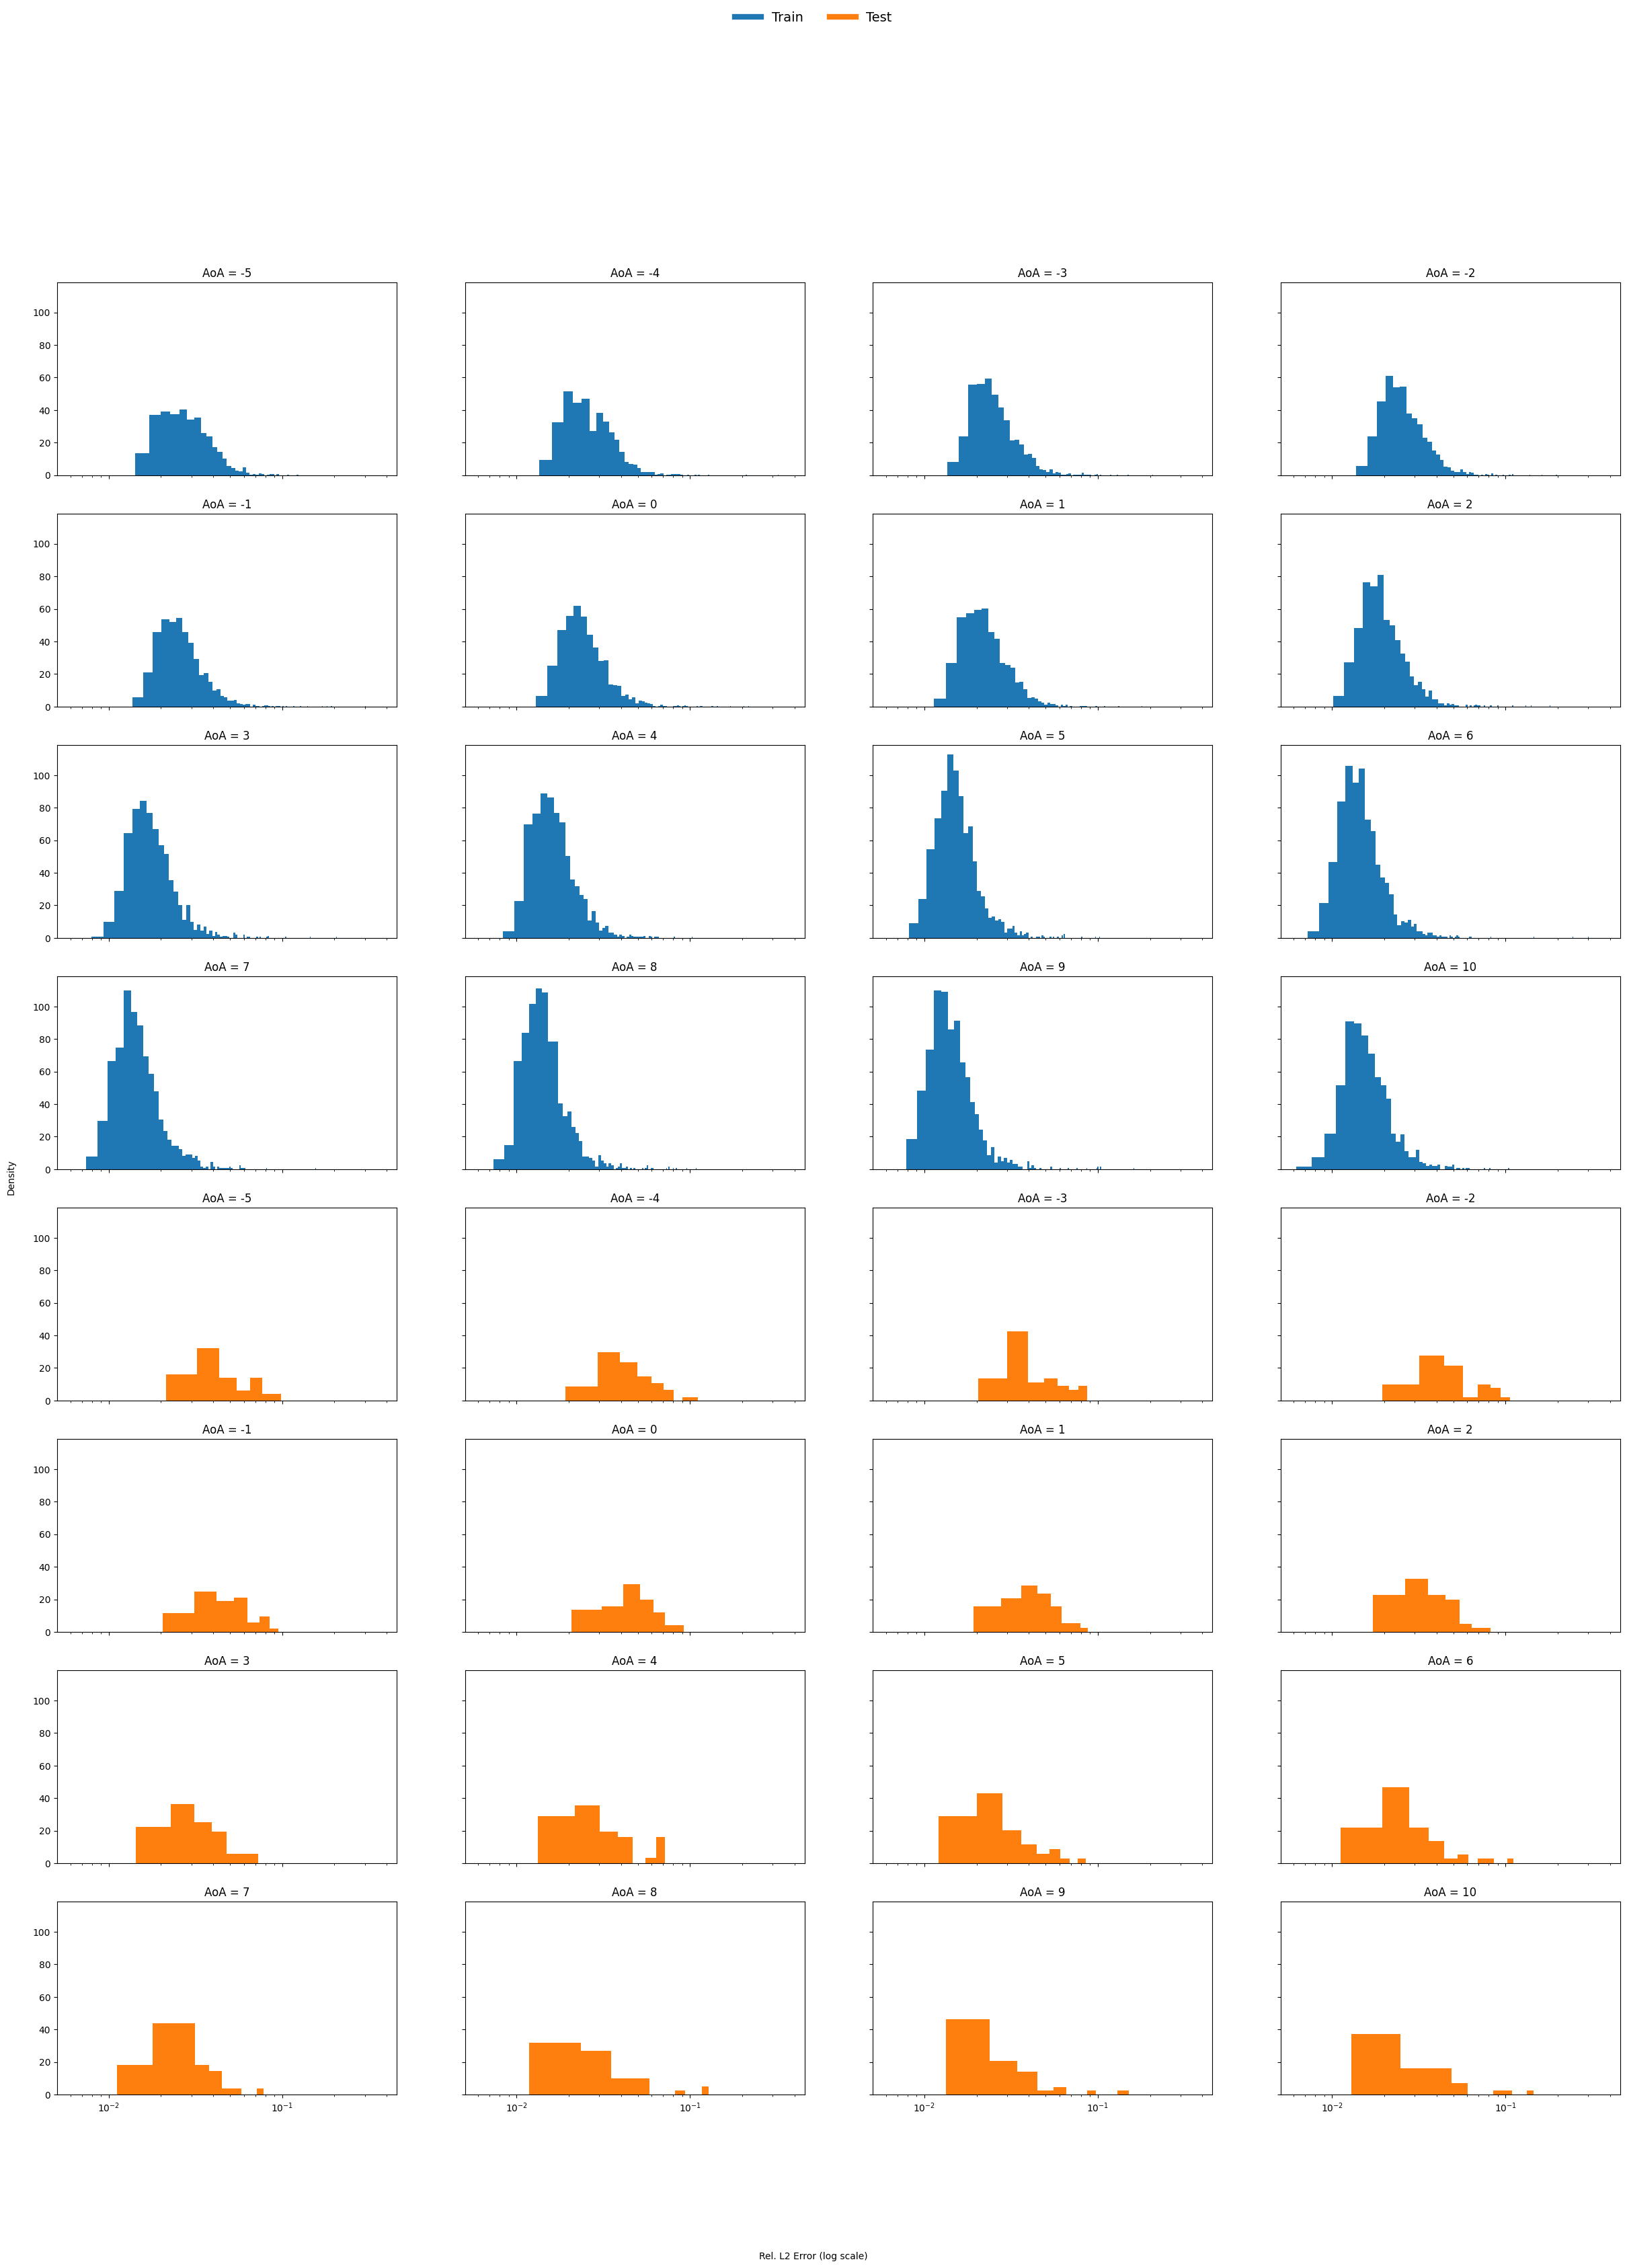

In [13]:
fig, axes = plt.subplots(8, 4, figsize=(30, 35), sharex=True, sharey=True)
axes = axes.flatten()

aoas = global_features['aoa'][:n_train]
lp_losses_tmp = lp_losses[:n_train]

print("Train Rel. L2 Error")
train_errors = []
i = 0
for aoa in aoa_list:
    mask = (aoas == aoa)
    errors = lp_losses_tmp[mask]
    train_errors.append(np.mean(errors))

    axes[i].hist(errors, bins='auto', color=train_color, density=True)
    axes[i].set_xscale("log")
    axes[i].set_title(f"AoA = {aoa}")
    print(f"AoA={aoa}:  {train_errors[i]}")
    i += 1


aoas = global_features['aoa'][n_train:]
lp_losses_tmp = lp_losses[n_train:]

print("\nTest Rel. L2 Error")
test_errors = []

for aoa in aoa_list:
    mask = (aoas == aoa)
    errors = lp_losses_tmp[mask]
    test_errors.append(np.mean(errors))

    axes[i].hist(errors, bins='auto', color=test_color, density=True)
    axes[i].set_xscale("log")
    axes[i].set_title(f"AoA = {aoa}")
    print(f"AoA={aoa}:  {test_errors[i-len(aoa_list)]}")
    i += 1


fig.text(0.5, 0.04, 'Rel. L2 Error (log scale)', ha='center')
fig.text(0.1, 0.5, 'Density', va='center', rotation='vertical')
handles = [
    plt.Line2D([0], [0], color=train_color, lw=6, label='Train'),
    plt.Line2D([0], [0], color=test_color, lw=6, label='Test')
]
fig.legend(handles=handles, loc='upper center', ncol=2, fontsize=14, frameon=False)

plt.show()

### The worst sample

In [14]:
worst_idx = int(np.argmax(ratio_losses))
median_loss = np.median(ratio_losses)
median_idx = int(np.argsort(np.abs(ratio_losses - median_loss))[0])
aoas = global_features['aoa']

goe440, aoa=2
Rel. L2 Errors: press=0.06816300004720688 friction_x=0.10303910076618195, friction_y=0.19620291888713837
CL: pred=1.387265920639038, truth=1.393654247
CD: pred=0.007542612496763468, truth=0.01594757351
CL/CD: pred=183.92379760742188, truth=87.38973650920013
goe440, aoa=3
Rel. L2 Errors: press=0.07152751088142395 friction_x=0.14877833425998688, friction_y=0.2977744936943054
CL: pred=1.4792933464050293, truth=1.485803957
CD: pred=0.011644084006547928, truth=0.01751325101
CL/CD: pred=127.04248046875, truth=84.83884323656478


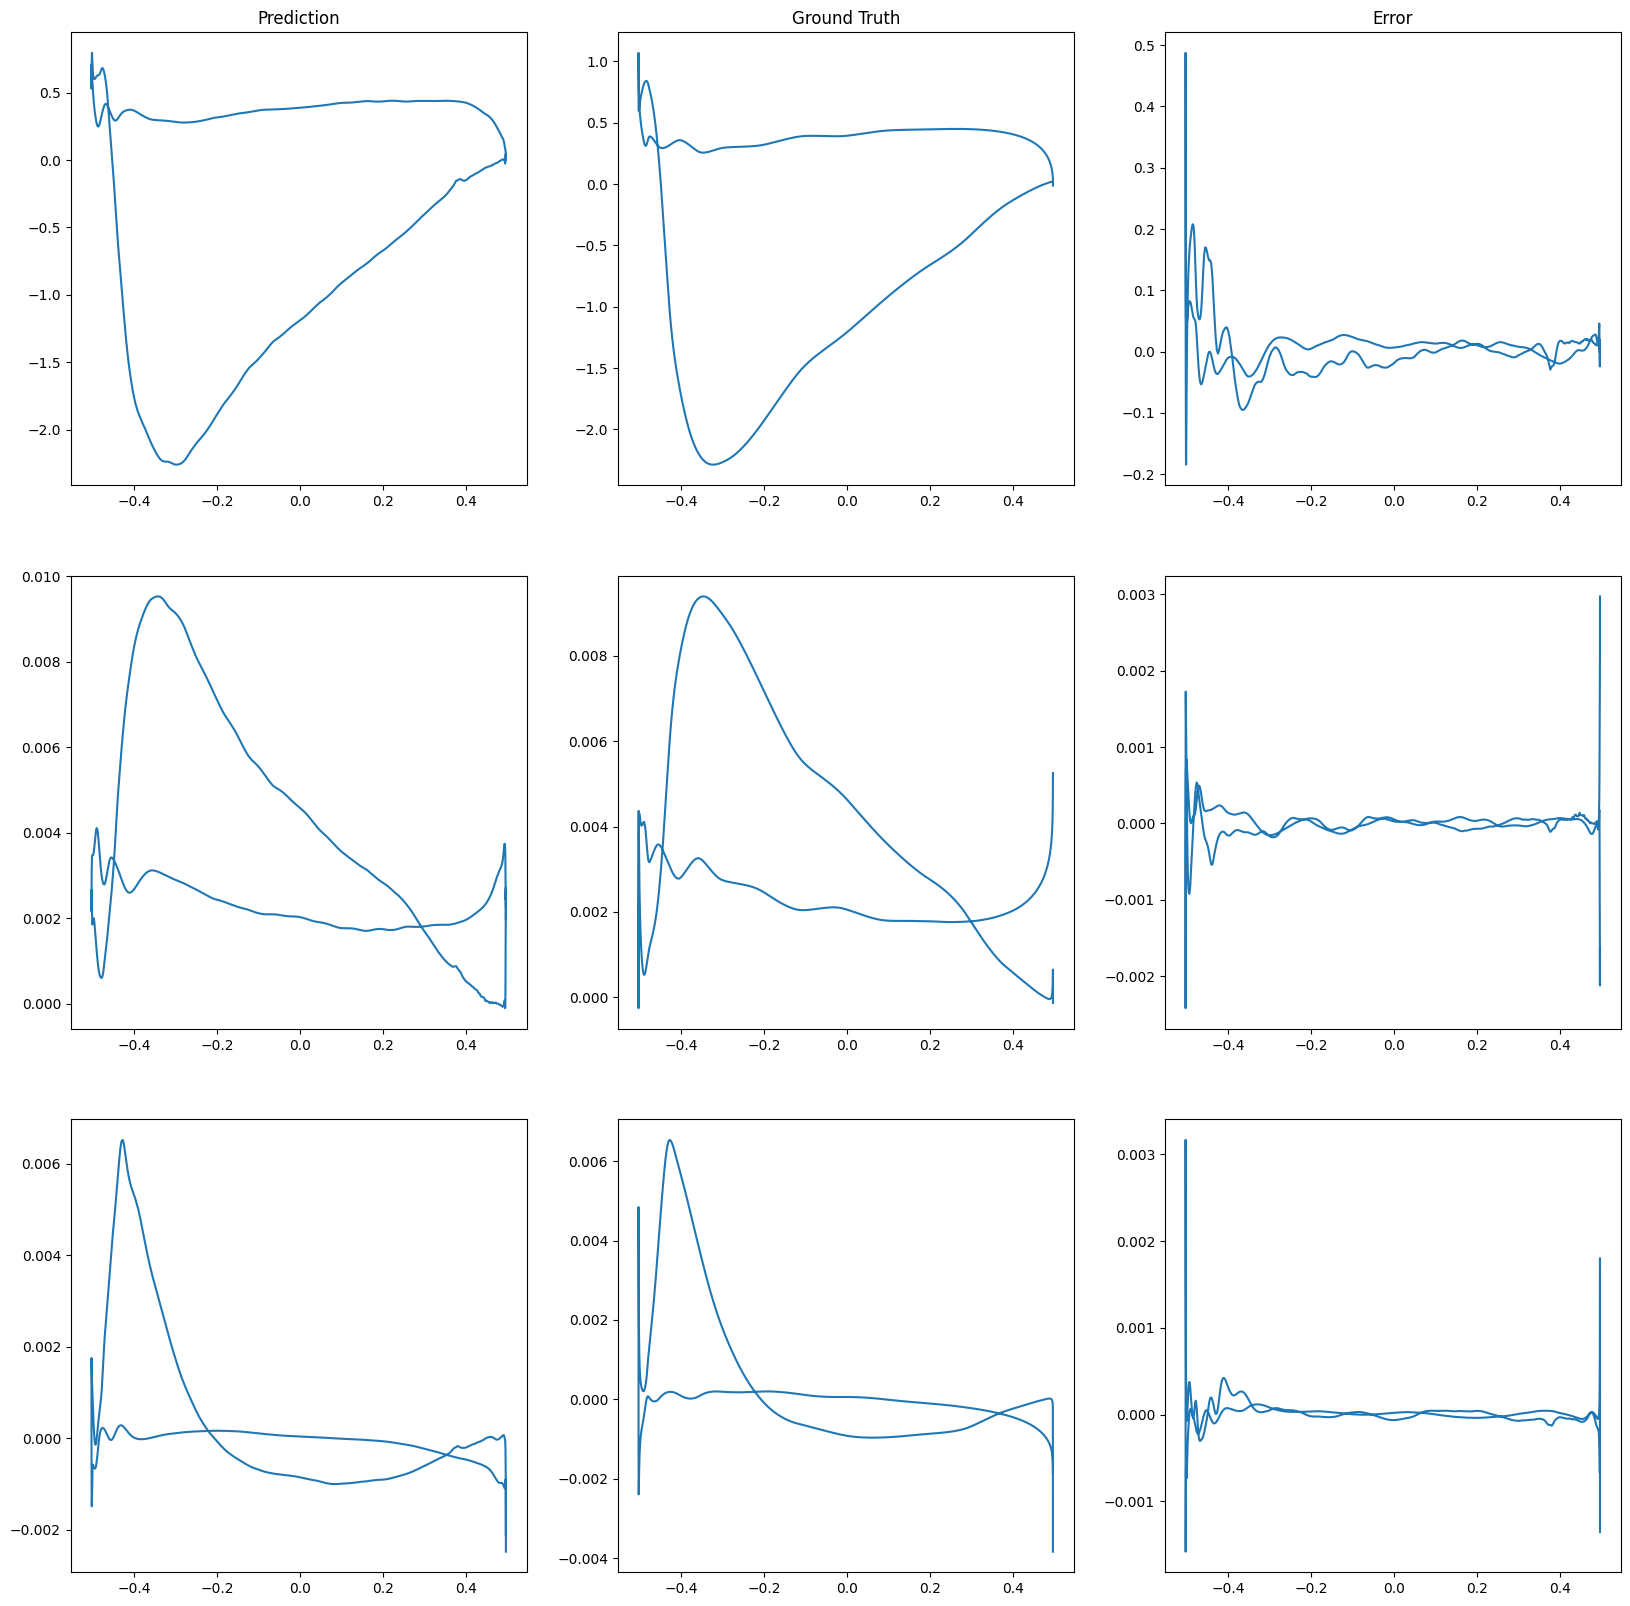

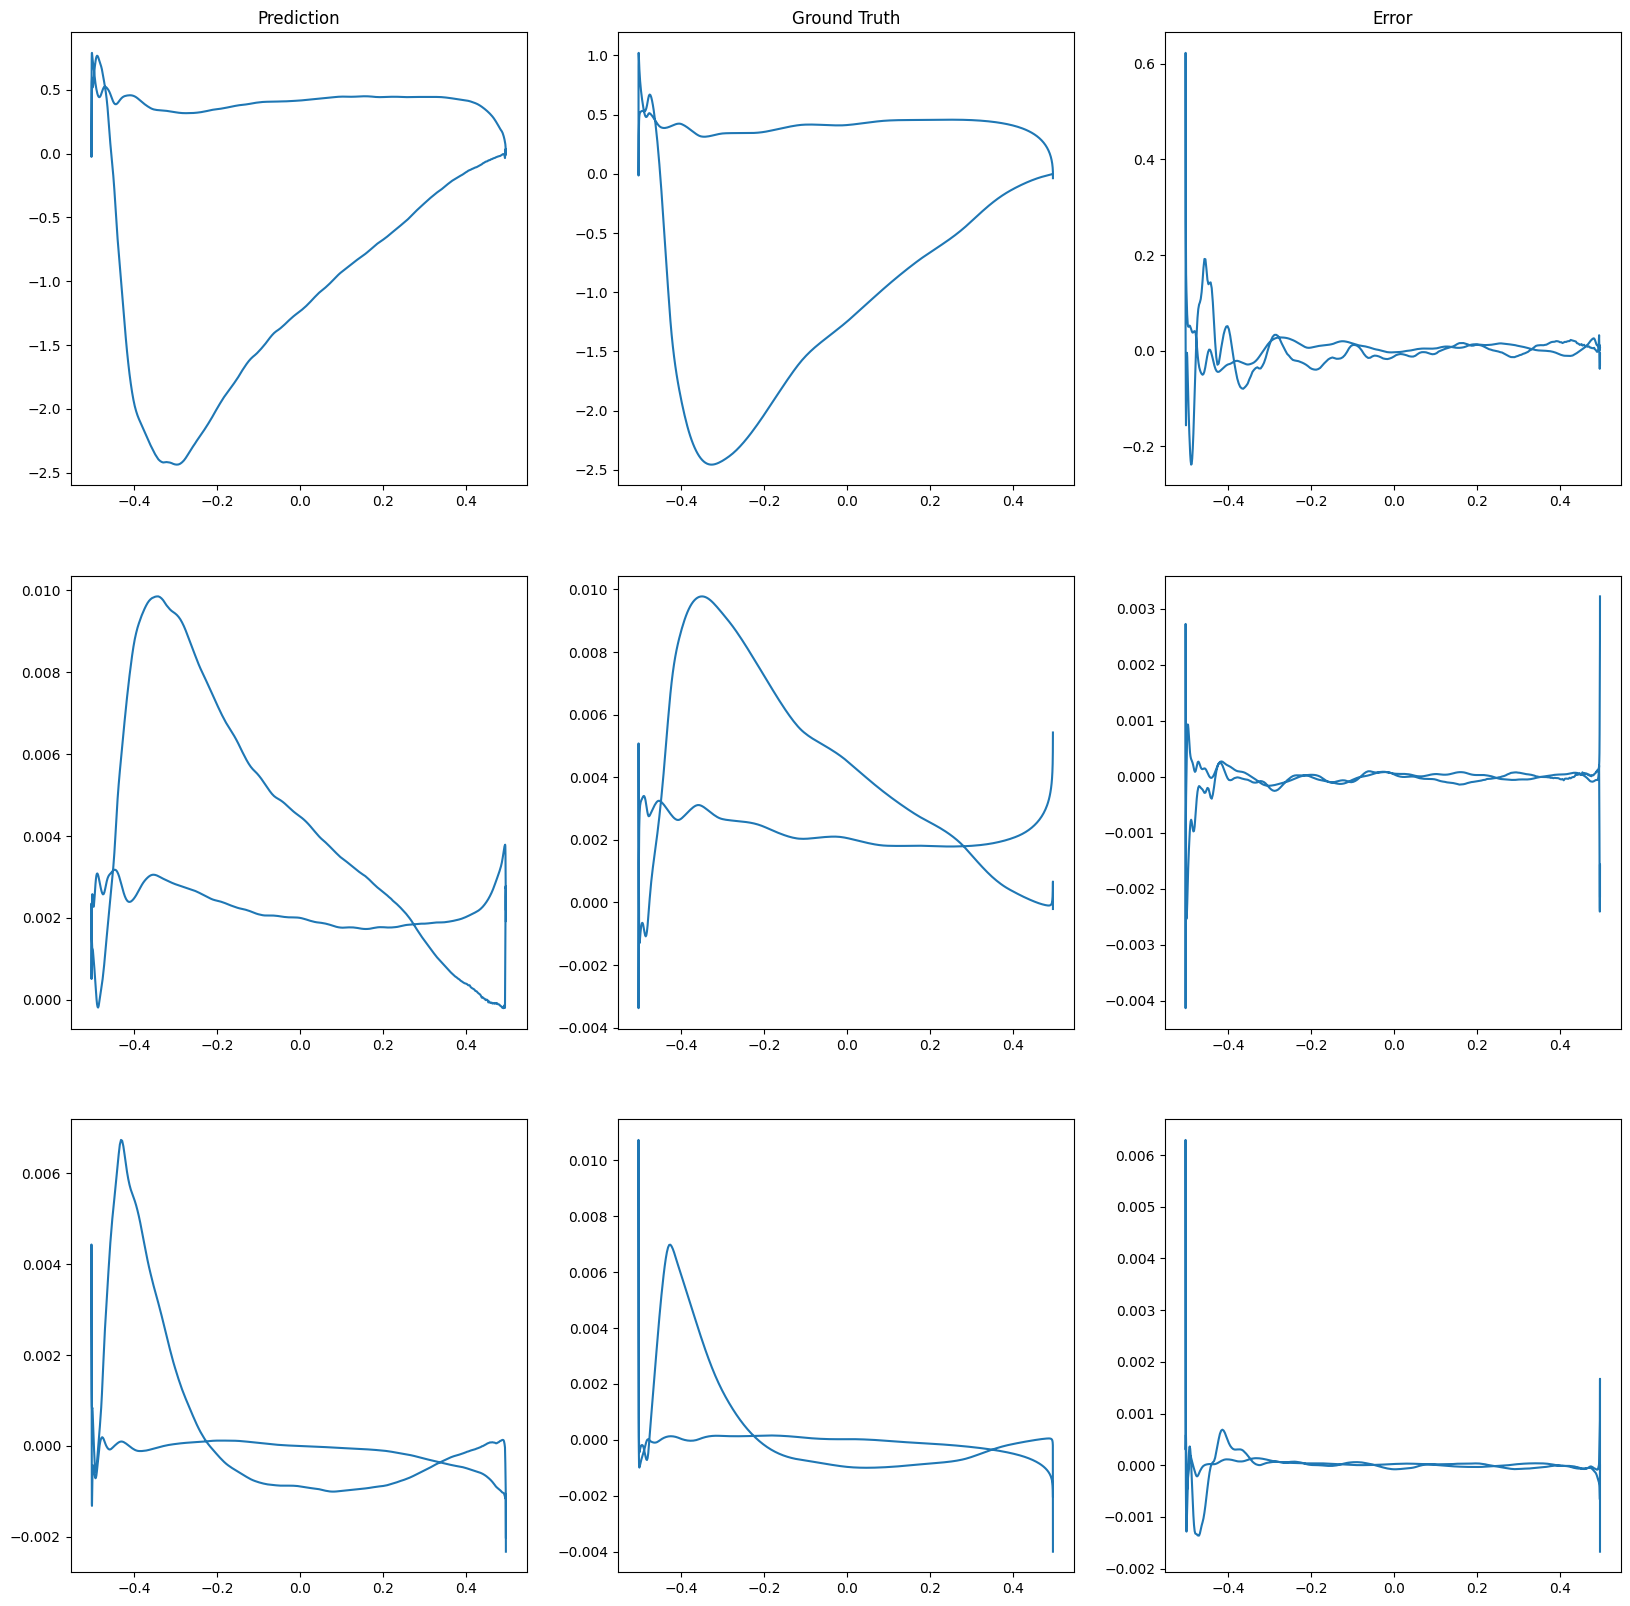

In [19]:
for idx in [worst_idx, worst_idx + 1]:

    print(f"{global_features['name'][idx]}, aoa={aoas[idx]}")

    ratio_pred, ratio_gt, cl_pred, cd_pred, cl_gt, cd_gt, lploss_val, press_loss_val, friction_x_loss_val, friction_y_loss_val = eval_sample(idx, plot=True)
    print(f"Rel. L2 Errors: press={press_loss_val.item()} friction_x={friction_x_loss_val.item()}, friction_y={friction_y_loss_val.item()}")
    print(f"CL: pred={cl_pred.item()}, truth={cl_gt}")
    print(f"CD: pred={cd_pred.item()}, truth={cd_gt}")
    print(f"CL/CD: pred={ratio_pred.item()}, truth={ratio_gt}")

### The median sample

hq2090sm, aoa=-5
10977
Rel. L2 Errors: press=0.03262980654835701 friction_x=0.0315135233104229, friction_y=0.047663137316703796
CL: pred=-0.312677800655365, truth=-0.3120936507
CD: pred=0.008904244750738144, truth=0.009298476897
CL/CD: pred=-35.1155891418457, truth=-33.56395398483937


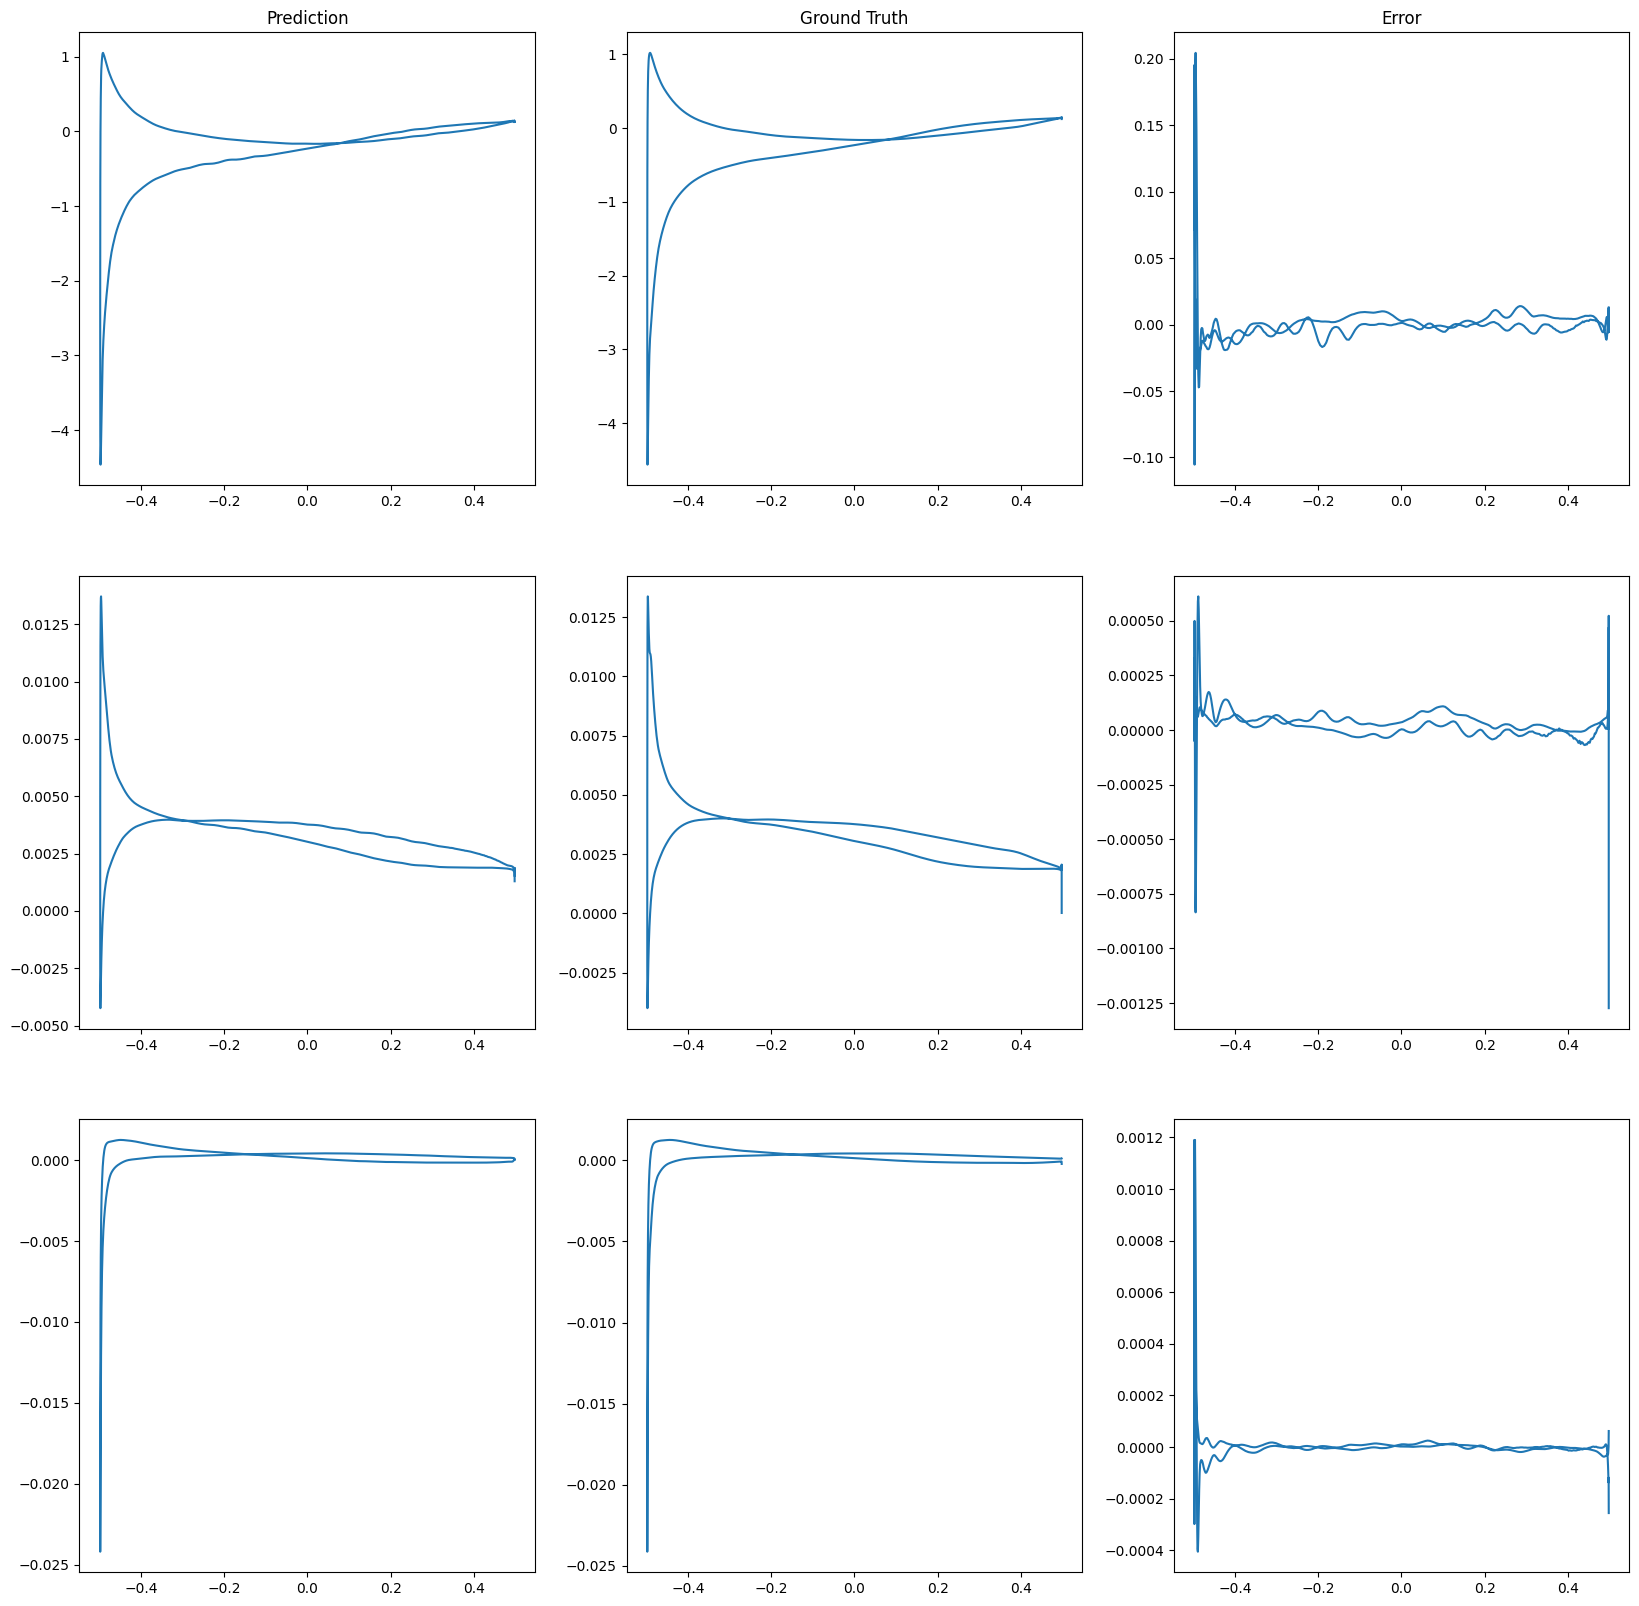

In [20]:
print(f"{global_features['name'][median_idx]}, aoa={global_features['aoa'][median_idx]}")
print(median_idx)

ratio_pred, ratio_gt, cl_pred, cd_pred, cl_gt, cd_gt, lploss_val, press_loss_val, friction_x_loss_val, friction_y_loss_val = eval_sample(median_idx, plot=True)
print(f"Rel. L2 Errors: press={press_loss_val.item()} friction_x={friction_x_loss_val.item()}, friction_y={friction_y_loss_val.item()}")
print(f"CL: pred={cl_pred.item()}, truth={cl_gt}")
print(f"CD: pred={cd_pred.item()}, truth={cd_gt}")
print(f"CL/CD: pred={ratio_pred.item()}, truth={ratio_gt}")